# Test Kalman Filter

## Setup

This was run locally

In [10]:
%%capture
!pip install h5py
!pip install filterpy
!pip install pykalman

In [11]:
import h5py
import numpy as np
import filterpy
import filterpy
from matplotlib import pyplot as plt
import pykalman
%matplotlib inline 

In [71]:
def simple_filter_wrist(data, hand, cam='upper'):
    time = data[f'vid/{cam}/color/time'] - data[f'vid/{cam}/color/time'][0]
    xy=np.ma.array(data[f'vid/{cam}/pose/mp-hands/{hand}/keypoints/color'][:,0,0:2])
    conf=data[f'vid/{cam}/pose/mp-hands/{hand}/confidence'][:]
    valid = np.any(xy!=0, axis=1) + conf>.45
    xy[np.logical_not(valid)]=np.ma.masked
    return (time, xy, conf)

def plot_filter_out(times, Zs, xs, title):
    ms=1
    plt.figure(figsize=(8,5), dpi= 200, facecolor='w', edgecolor='k')
    plt.subplot(211)
    plt.tight_layout(pad=3)
    plt.plot(times, Zs[:, 0],'.', label="raw (conf>.15; not x=0&y=0)", color='red', markersize=ms)
    plt.plot(times,xs[:, 0],'.', label='smoothed', color='blue', markersize=ms)
    plt.title(f'{title} - x')
    plt.subplot(212)
    plt.plot(times, Zs[:, 1],'.', label="raw (conf>.1; not x=0&y=0)",color='red', markersize=ms)
    plt.plot(times,xs[:, 1],'.', label='smoothed', color='blue', markersize=ms)
    plt.legend(bbox_to_anchor=(1.01,0.5), loc="center left")
    plt.title(f'{title} - y')

### Load File
You will need to change the filename:

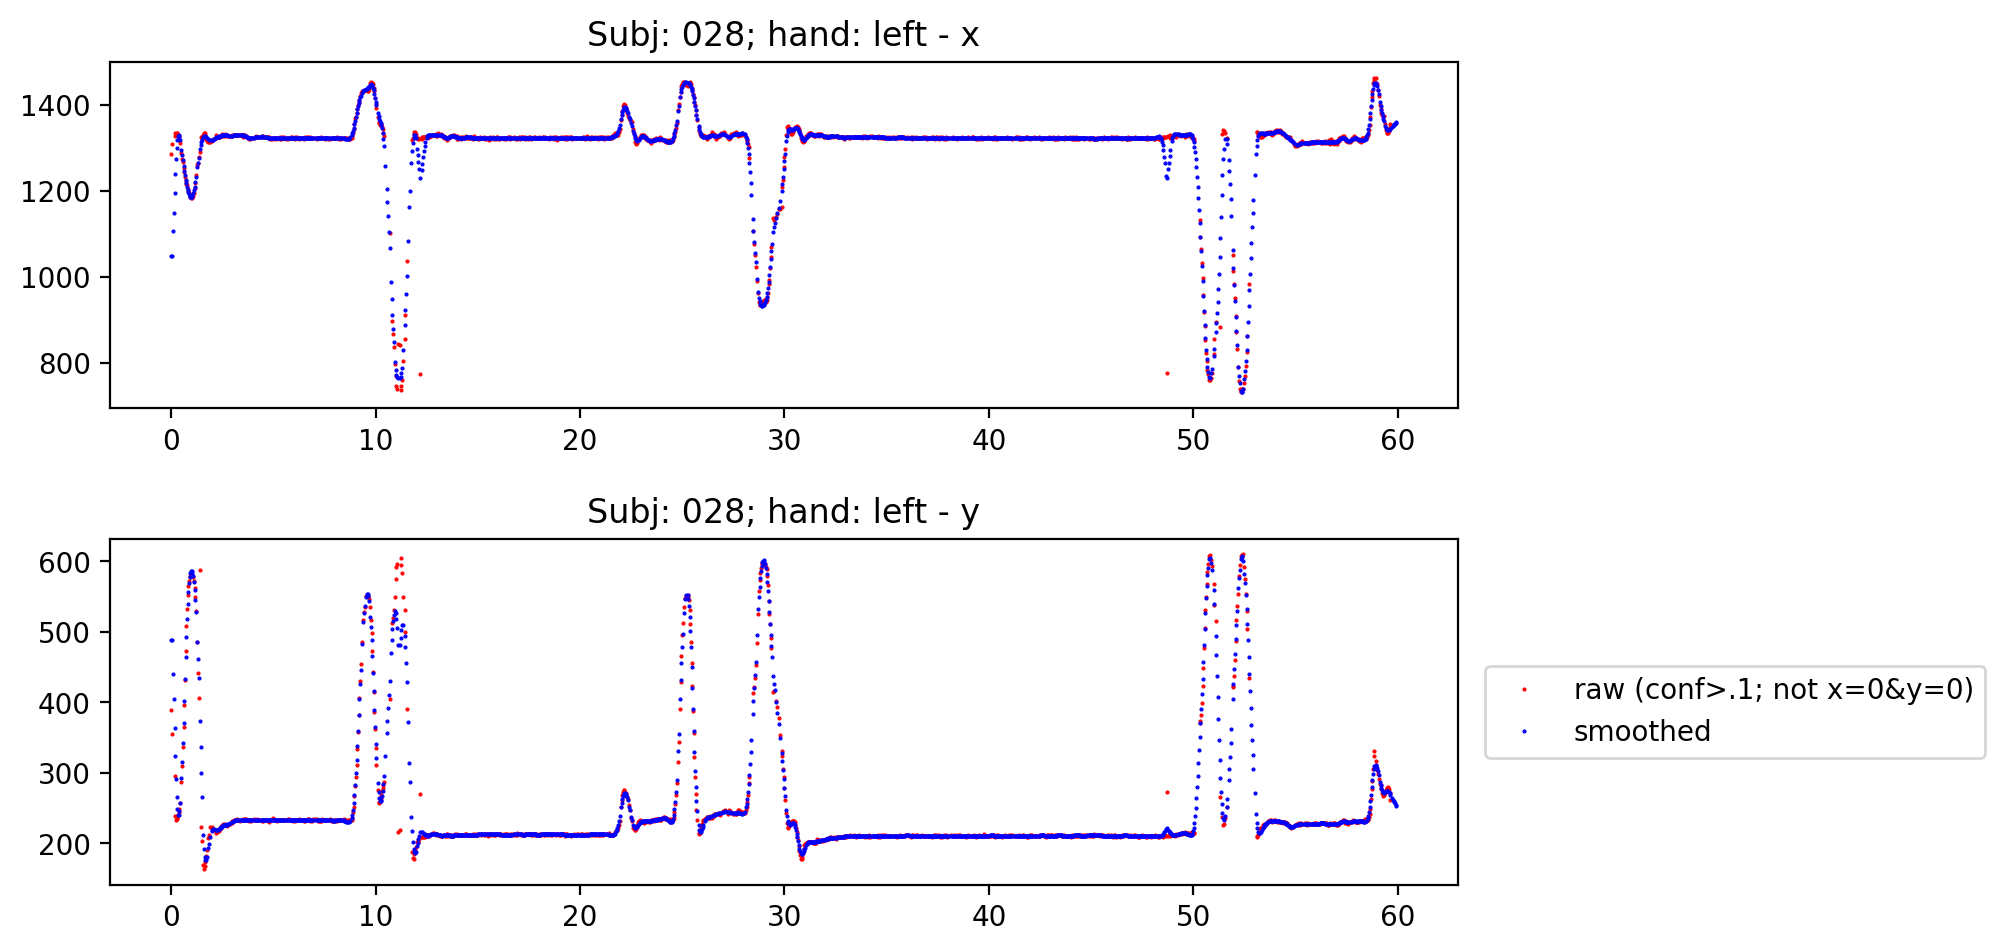

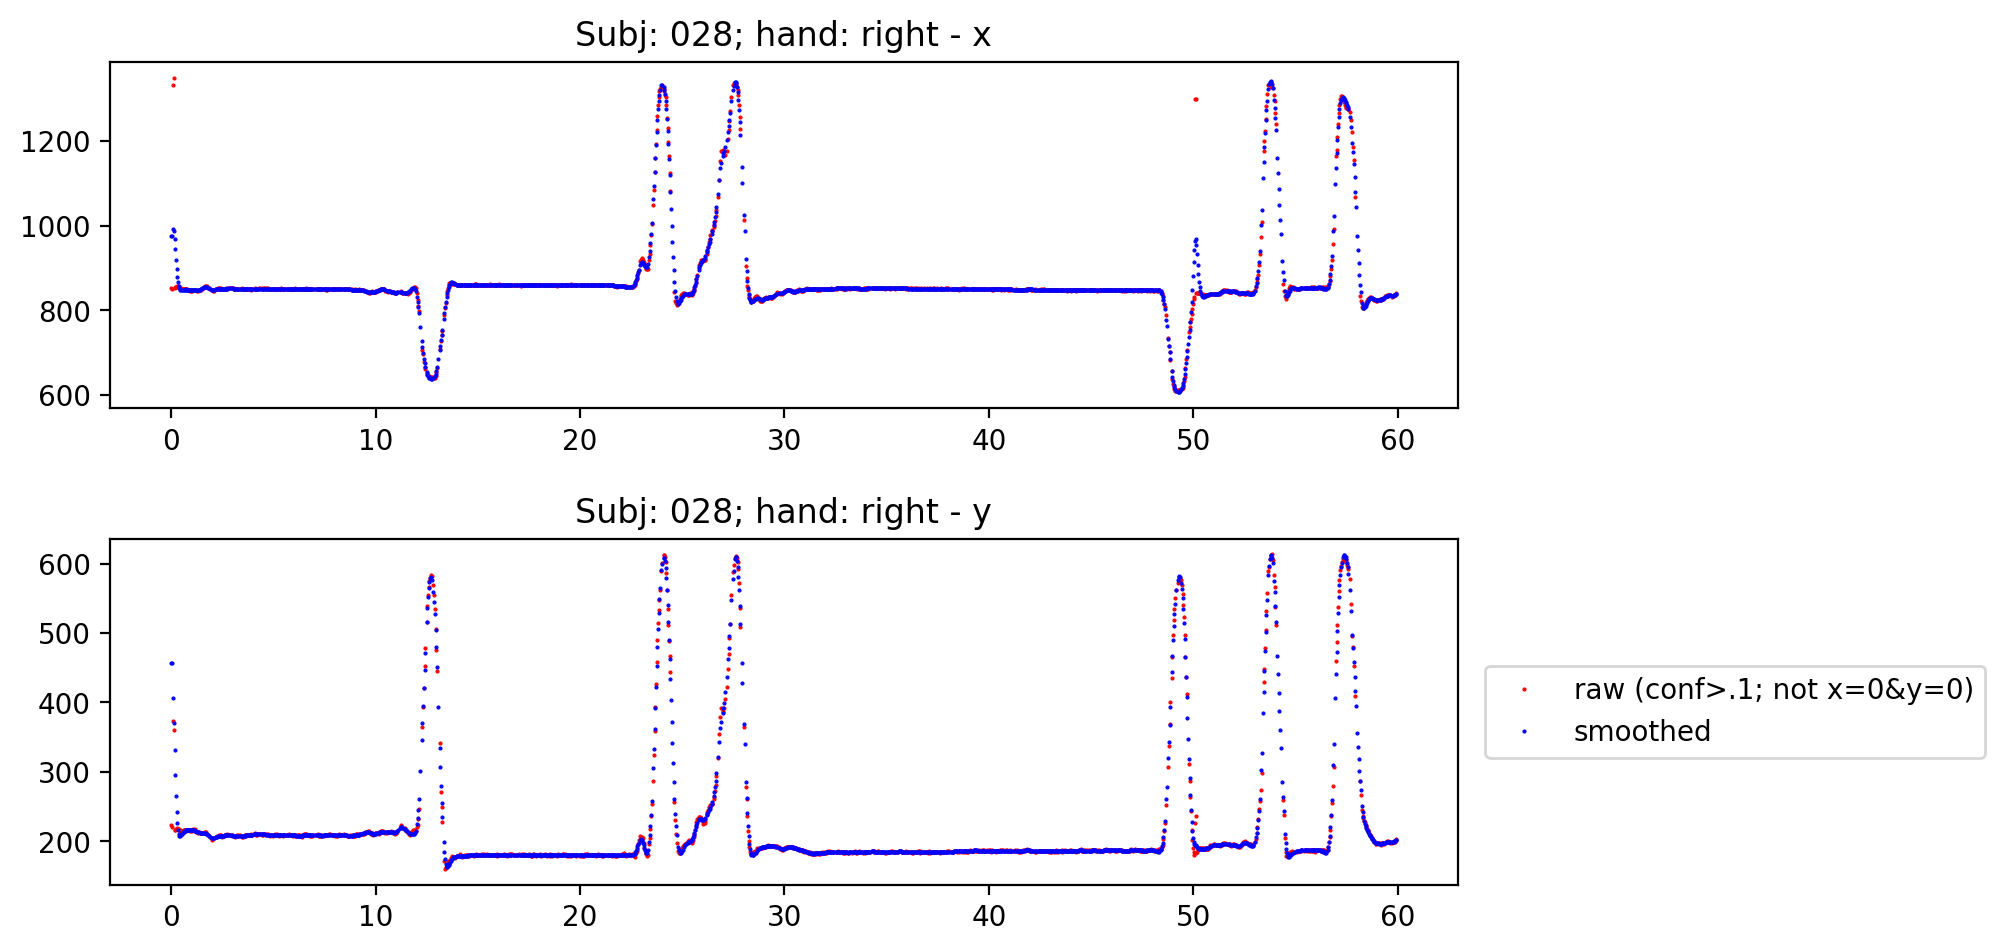

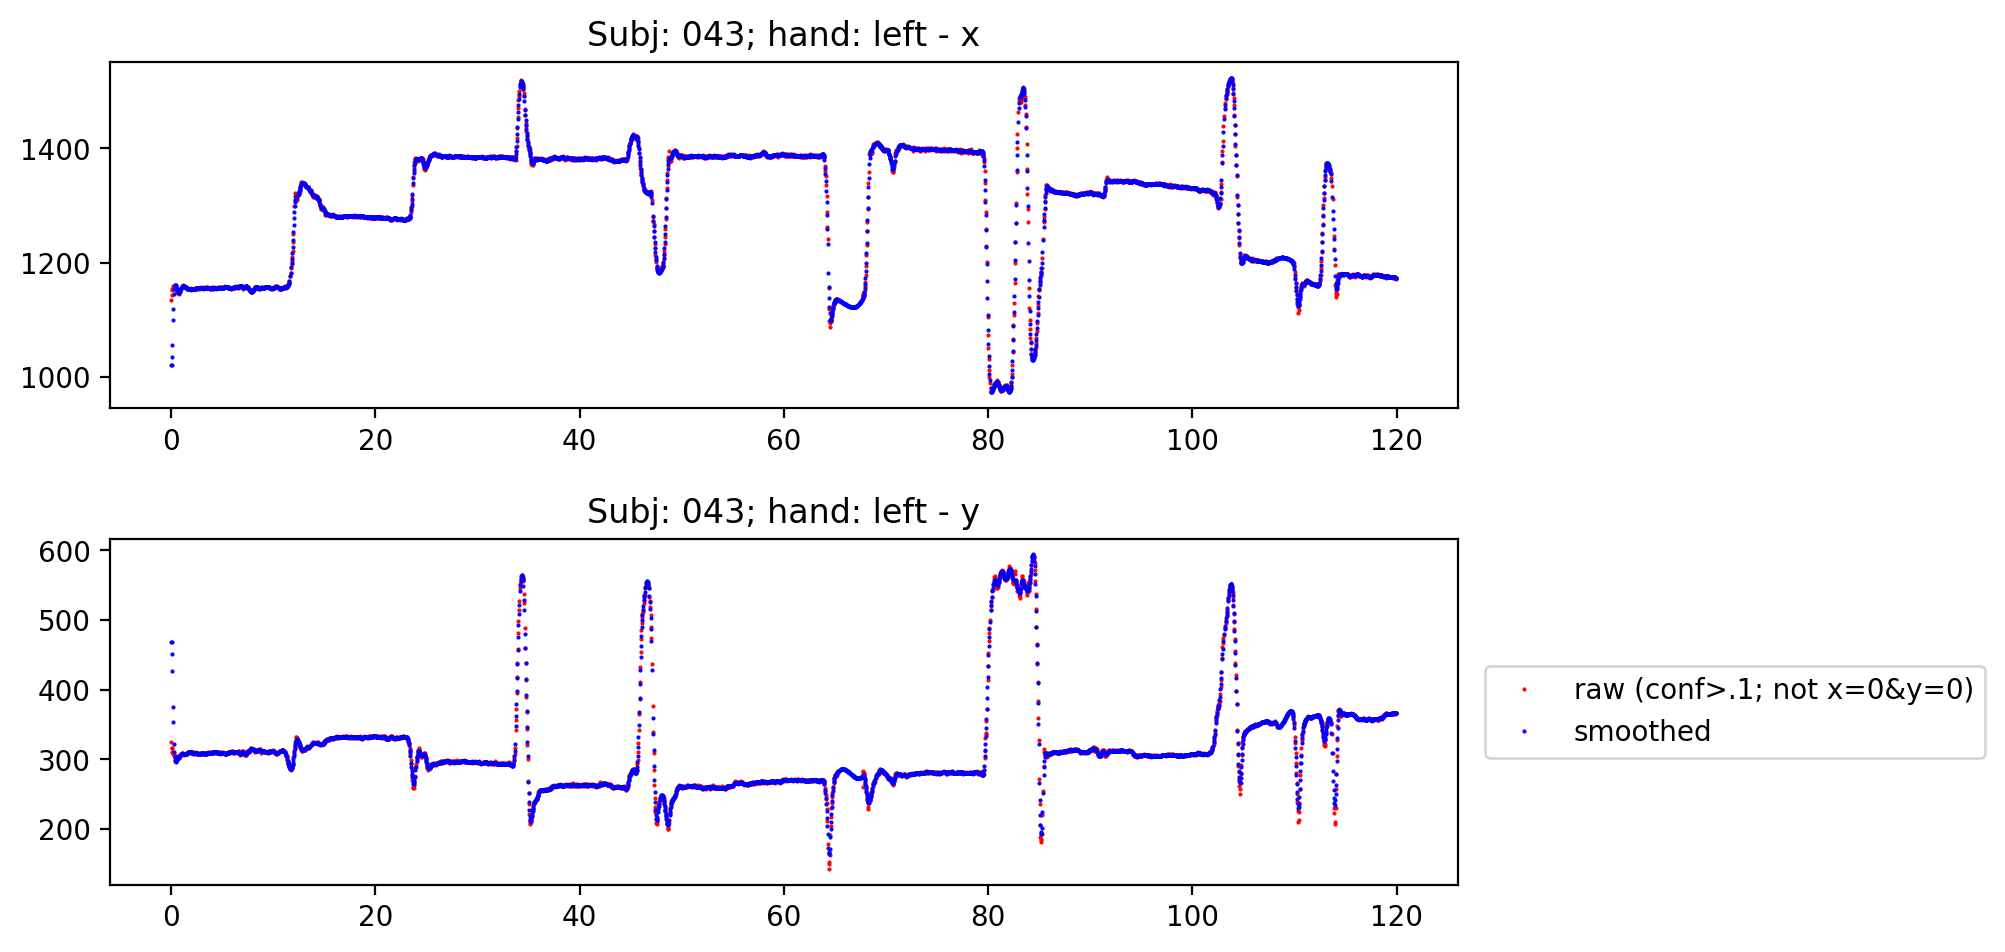

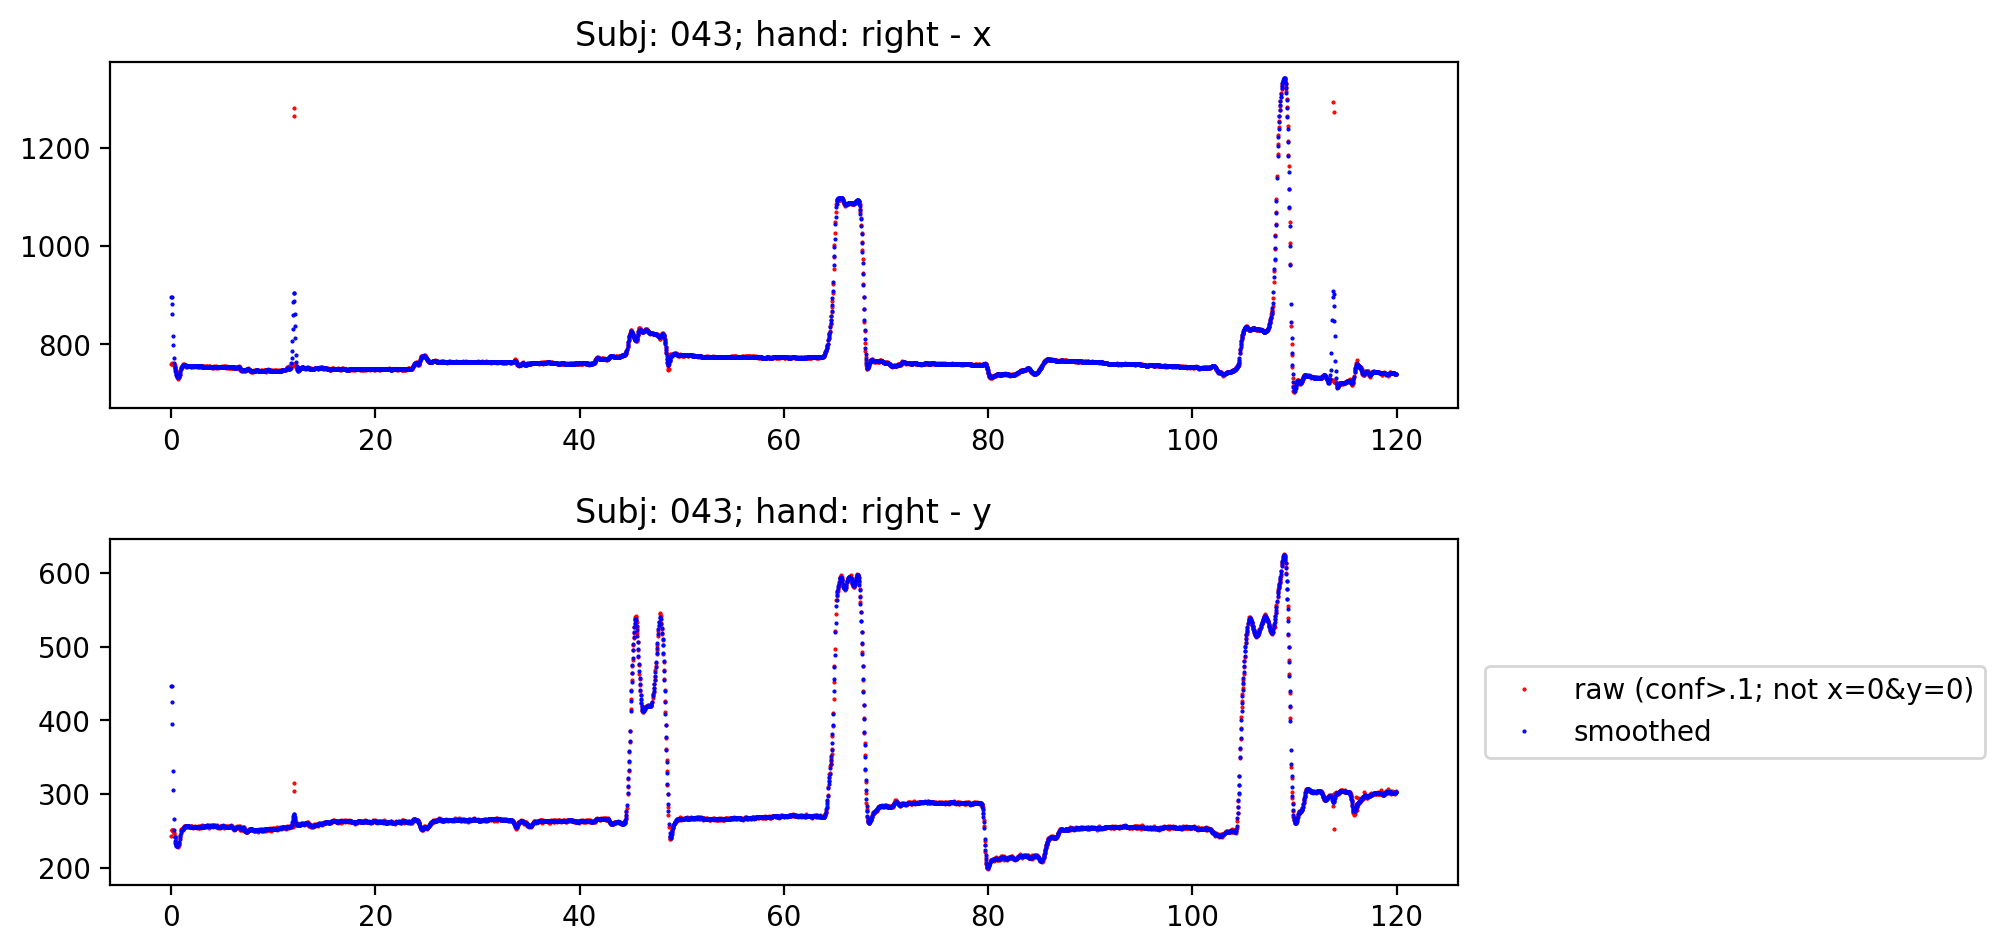

In [76]:
# image_width = 1920
image_height = 1080
# Measurement function (we measure x and y positions)
H = np.array([[1,0,0,0],
                 [0,1,0,0]])
# Initial vals
x0 = np.array([image_width/2, image_height/2, 0, 0]) # initial assumed state, center of image
P0 = np.array([[(image_width/4)**2, 0 ,0 ,0], # initially could be anywhere in frame
                 [0, (image_height/4)**2, 0, 0],
                 [0, 0 ,500, 0], # no clue what our initial velocity uncertanty is
                 [0, 0, 0, 500]])
# Transistion covariance
Q = np.array([[0,0,0,0],
              [0,0,0,0],
              [0,0,1,0],
              [0,0,0,1]])*(15**2)
# Observation covariance
R=np.eye(2)*(3**2)
for subj in ('028', '043'):
    for hand in ('left', 'right'):
        file_name=f'/home/mjsobrep/Downloads/data/{subj}/target-touch/full_data-novid.hdf5'
        cam='upper'
        data = h5py.File(file_name, 'r')
        # if confidence is less than .1, just skip
        times, Zs, confidences = simple_filter_wrist(data, hand)
        # state transistion matrix
        Fs = [np.array([[1, 0, dt, 0],
                [0, 1, 0, dt],
                [0, 0, 1, 0],
                [0, 0, 0, 1]]) for dt in np.diff(times)]
        kf = pykalman.KalmanFilter(transition_matrices=Fs, observation_matrices=H, 
                                   initial_state_mean=np.array([image_width/2, image_height/2, 0, 0]),
                                    observation_covariance=R, transition_covariance=Q)
        xs, _ = kf.smooth(Zs)
        plot_filter_out(times, Zs, xs, f'Subj: {subj}; hand: {hand}')

In [55]:
subj='028'
file_name=f'/home/mjsobrep/Downloads/data/{subj}/target-touch/full_data-novid.hdf5'
cam='upper'
hand='right'
data = h5py.File(file_name, 'r')
t, x, c = simple_filter_wrist(data, hand='right')

In [57]:
np.where(x.mask)

(array([ 272,  272,  273,  273,  296,  296,  297,  297,  317,  317,  319,
         319,  323,  323,  612,  612,  613,  613,  614,  614,  615,  615,
         616,  616,  694,  694,  695,  695,  697,  697, 1223, 1223, 1248,
        1248, 1249, 1249, 1343, 1343, 1361, 1361, 1362, 1362, 1363, 1363,
        1364, 1364, 1365, 1365, 1366, 1366, 1367, 1367, 1431, 1431, 1455,
        1455, 1457, 1457, 1458, 1458, 1459, 1459, 1460, 1460, 1461, 1461]),
 array([0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
        0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
        0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1]))